# Missiles and Rockets


We are going to try and create a model that can tell the difference between missiles and rockets

In [30]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [18]:
PATH = "/home/ubuntu/data/missilesrockets/"
sz=224



In [33]:
os.listdir(PATH)


['valid', 'train']

In [23]:
os.listdir(f'{PATH}validation')

['rocket', 'missile']

In [26]:
files = os.listdir(f'{PATH}validation/rocket')[:5]
files

['13. picture-of-space-rocket-7.jpg',
 '1. free-picture-of-space-rocket-since-fire-needs-oxygen-to-burn-how-do-rockets-work-in-the-vacuum.jpg',
 '12. 21736195-space-rocket.jpg',
 '10. space-rocket-start-.jpg',
 '6. shutterstock_308948921.jpg']

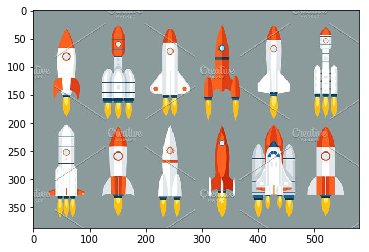

In [37]:
img = plt.imread(f'{PATH}valid/rocket/{files[3]}')
plt.imshow(img)

## Quick Start Model


In [41]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.860626   0.707237   0.571429  
    1      0.82008    0.421761   0.857143        



[array([ 0.42176]), 0.8571428656578064]

### Lets analyze the pictures

In [42]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [43]:
data.classes

['missile', 'rocket']

In [44]:
log_preds = learn.predict()
log_preds.shape

(35, 2)

In [45]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [46]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0],4,replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [47]:
def plot_val_with_titleplot_val (idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [48]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [49]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


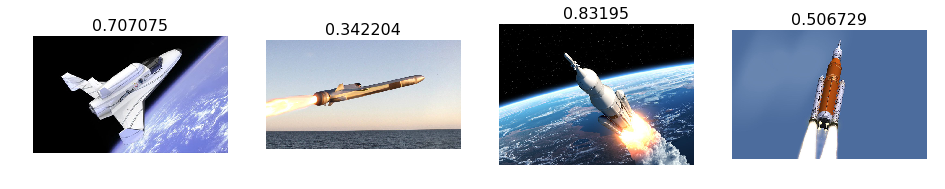

In [50]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


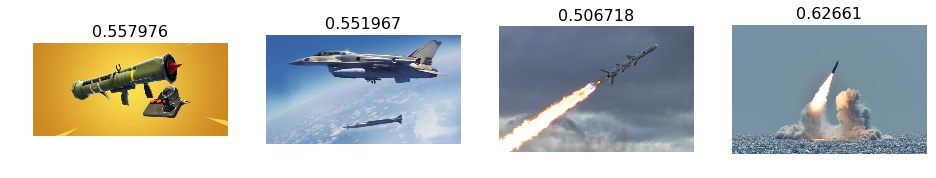

In [51]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [52]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


Most correct cats


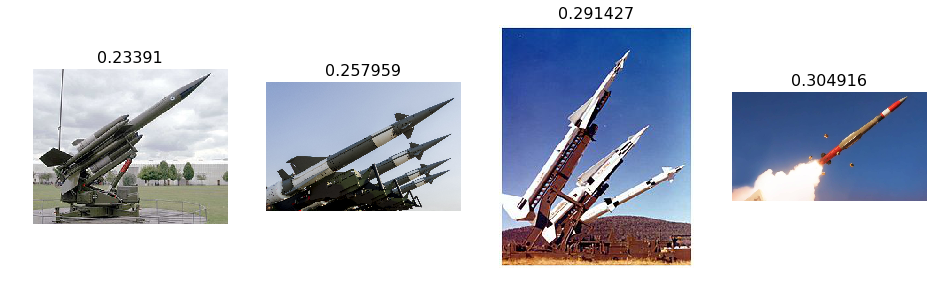

In [53]:
plot_val_with_title(most_by_correct(0, True), "Most correct missiles")

Most correct rockets


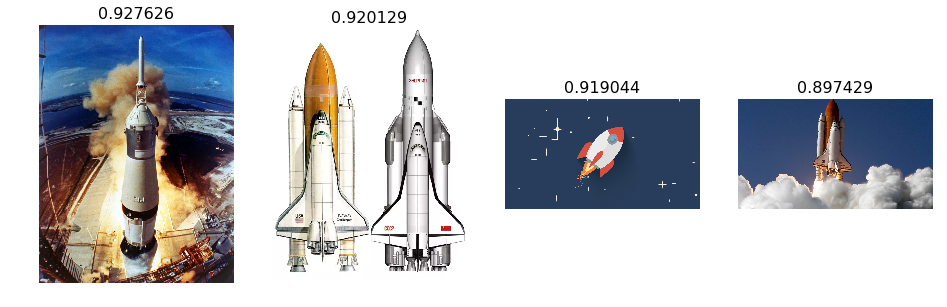

In [55]:
plot_val_with_title(most_by_correct(1, True), "Most correct rockets")

Most incorrect missile


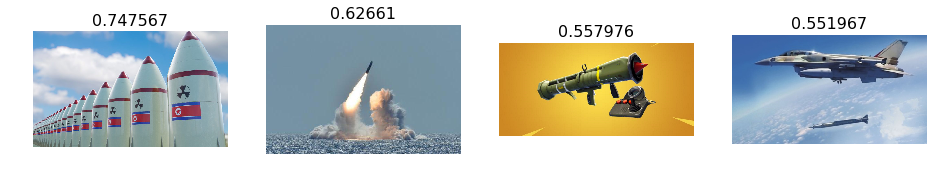

In [56]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect missile")

In [58]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect rockets")

Most incorrect rockets


Most uncertain predictions


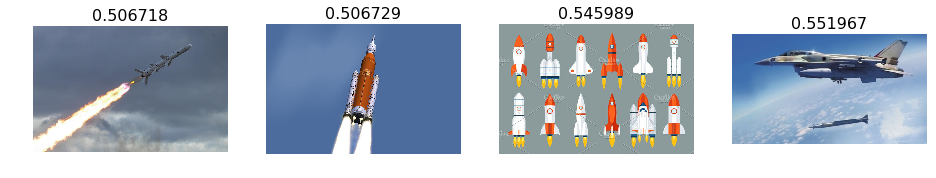

In [59]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")